In [1]:
from pprint import pprint
import os
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import mplleaflet as leaf
from importlib import reload

In [2]:
base_path = os.path.join('C:\\', 'Users', 'glenn', 'src', 'pycommute')
data_directory = os.path.join(base_path, 'data')
dataframe_file = os.path.join(data_directory, 'trondheim_100m.hdf5')
df = pd.read_hdf(dataframe_file)
df

,origin lat,origin lon,origin address,destination lat,destination lon,destination address,destination label,travel mode,distance text,distance value,duration text,duration value,status
0,63.418312,10.358785,"Viktor Baumanns vei 37, 7020 Trondheim, Norway",63.412328,10.404471,"Klæbuveien 125, 7031 Trondheim, Norway",Lerkendal Stadion,driving,6.5 km,6491,14 mins,826,OK
1,63.418312,10.358785,"Viktor Baumanns vei 37, 7020 Trondheim, Norway",63.428781,10.473247,"Landbruksvegen 2, 7047 Trondheim, Norway",Ikea,driving,10.6 km,10604,16 mins,955,OK
2,63.418312,10.360795,"Riiser-larsens vei 18, 7020 Trondheim, Norway",63.412328,10.404471,"Klæbuveien 125, 7031 Trondheim, Norway",Lerkendal Stadion,driving,5.9 km,5941,13 mins,759,OK
3,63.418312,10.360795,"Riiser-larsens vei 18, 7020 Trondheim, Norway",63.428781,10.473247,"Landbruksvegen 2, 7047 Trondheim, Norway",Ikea,driving,10.1 km,10054,15 mins,888,OK
4,63.418312,10.362806,"Riiser-larsens vei 20, 7020 Trondheim, Norway",63.412328,10.404471,"Klæbuveien 125, 7031 Trondheim, Norway",Lerkendal Stadion,driving,5.9 km,5941,13 mins,759,OK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5699,63.438097,10.477404,"Arkitekt Ebbells veg 10, 7053 Ranheim, Norway",63.428781,10.473247,"Landbruksvegen 2, 7047 Trondheim, Norway",Ikea,transit,1.4 km,1388,19 mins,1126,OK
5700,63.438097,10.479415,"Arkitekt Ebbells veg 10, 7053 Ranheim, Norway",63.412328,10.404471,"Klæbuveien 125, 7031 Trondheim, Norway",Lerkendal Stadion,transit,9.3 km,9294,50 mins,3010,OK
5701,63.438097,10.479415,"Arkitekt Ebbells veg 10, 7053 Ranheim, Norway",63.428781,10.473247,"Landbruksvegen 2, 7047 Trondheim, Norway",Ikea,transit,1.5 km,1518,20 mins,1212,OK
5702,63.438097,10.481425,"Arkitekt Ebbells veg 16, 7053 Ranheim, Norway",63.412328,10.404471,"Klæbuveien 125, 7031 Trondheim, Norway",Lerkendal Stadion,transit,9.3 km,9313,50 mins,3024,OK


Get destination coordinates

In [92]:
lerkendal_coords = tuple(df.loc[df['destination label'] == 'Lerkendal Stadion'][['destination lat', 'destination lon']].iloc[0])
ikea_coords = tuple(df.loc[df['destination label'] == 'Ikea'][['destination lat', 'destination lon']].iloc[0])

((63.4123278, 10.404471), (63.428781, 10.4732474))

Create matrices

In [36]:
def arrays_to_matrices(latitudes, longitudes, values, return_coordinates='list'):
    """
    Function turns lists of latitudes, longitudes and values into matrix values where the first axis (0) is latitudes, and the second axis (1) is longitudes.
    """
    lats = sorted(set(latitudes))
    longs = sorted(set(longitudes))
    i_lats = {}
    for i, lat in enumerate(lats):
        i_lats[lat] = i
    i_lons = {}
    for i, lon in enumerate(lons):
        i_lons[lon] = i
    vals = np.full((len(lats), len(lons)), np.nan)
    for lat, lon, val in zip(latitudes, longitudes, values):
        vals[i_lats[lat], i_lons[lon]] = val
    
    if return_coordinates is None:
        return vals
    elif return_coordinates == 'matrix':
        lats, lons = np.meshgrid(lats, lons)
    elif return_coordinates == lists:
        pass
    else:
        raise ValueError('`return_coordinates` must be either type None, strings `list` or `matrix`.')
    
    return lats, lons, vals
    


Get arrays

In [42]:
def get_mode(df, travel_mode, destination_label):
    selection = df.loc[
        (df['travel mode'] == travel_mode) &
        (df['destination label'] == destination_label)
    ]
    out = {
        'latitudes': np.array(selection['origin lat']),
        'longitudes': np.array(selection['origin lon']),
        'durations': np.array(selection['duration value']),
        'distances': np.array(selection['distance value']),
    }

    return out


In [57]:
d_lerkendal_driving = get_mode(df, 'driving', 'Lerkendal Stadion')
d_lerkendal_transit = get_mode(df, 'transit', 'Lerkendal Stadion')
d_ikea_driving = get_mode(df, 'driving', 'Ikea')
d_ikea_transit = get_mode(df, 'transit', 'Ikea')

lats = d_lerkendal_driving['latitudes']
lons = d_lerkendal_driving['longitudes']

Compare

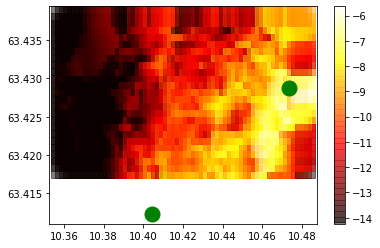

In [99]:
norm_ord = 2
top_cutoff_percent = 20 # Higher than this percentile (from top) get mapped to this percentile
score_multiplier = 1 / 60 # to minutes

scores = {
    'no_driving': np.linalg.norm((d_lerkendal_transit['durations'], d_ikea_transit['durations']), ord=norm_ord, axis=0),
    'lerkendal_driving': np.linalg.norm((d_lerkendal_driving['durations'], d_ikea_transit['durations']), ord=norm_ord, axis=0),
    'ikea_driving': np.linalg.norm((d_lerkendal_transit['durations'], d_ikea_driving['durations']), ord=norm_ord, axis=0),
    'all_driving': np.linalg.norm((d_lerkendal_driving['durations'], d_ikea_driving['durations']), ord=norm_ord, axis=0),
}

for key, score in scores.items():
    cutoff = np.percentile(score, 100-top_cutoff_percent)
    scores[key] = np.minimum(score, cutoff) * score_multiplier

score_args = {'x': lons, 'y': lats, 'c': -scores['all_driving'], 'cmap': 'hot', 'marker': 's', 's': 20**2, 'alpha': 0.5}
destination_args = {'x': (lerkendal_coords[1], ikea_coords[1]), 'y': (lerkendal_coords[0], ikea_coords[0]), 'c': 'green', 's': 15**2}

plt.figure()
plt.scatter(**score_args)
plt.colorbar()
plt.scatter(**destination_args)
plt.show()

In [96]:
plt.figure()
plt.scatter(**score_args)
plt.scatter(**destination_args)
leaf.show()